In [1]:
!git clone https://github.com/Jjioo/Plagiarism

Cloning into 'Plagiarism'...
remote: Enumerating objects: 107, done.
remote: Counting objects: 100% (107/107), done.
remote: Compressing objects: 100% (103/103), done.
remote: Total 107 (delta 4), reused 107 (delta 4), pack-reused 0
Receiving objects: 100% (107/107), 123.78 KiB | 1.72 MiB/s, done.
Resolving deltas: 100% (4/4), done.


In [2]:
%cd ..
%pwd

/


'/'

In [4]:
import pandas as pd
import os
# Load information about tasks and categories
file_info = pd.read_csv('/content/Plagiarism/file_information.csv')
test_info = pd.read_csv('/content/Plagiarism/test_info.csv')

# Load text data
txt_files = [doc for doc in os.listdir('/content/Plagiarism/txt_data') if doc.endswith('.txt')]
txt_content = [open(os.path.join('/content/Plagiarism/txt_data', _file), encoding='utf-8', errors='ignore').read()
               for _file in txt_files]


**Preprocess Text Data:**


In [5]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Tokenize text data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(txt_content)

# Convert text data to sequences
sequences = tokenizer.texts_to_sequences(txt_content)

# Pad sequences to a fixed length
max_seq_length = 100  # Adjust as needed
padded_sequences = pad_sequences(sequences, maxlen=max_seq_length, padding='post', truncating='post')


**Train, Validation, and Test Sets:**

In [7]:
from sklearn.model_selection import train_test_split

# Assuming 'Category' column in file_info indicates plagiarism
labels = (file_info['Category'] == 'non').astype(int)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, labels, test_size=0.2, random_state=42)

**LSTM Model:**

In [20]:
import warnings
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout, BatchNormalization
from keras.callbacks import LearningRateScheduler, EarlyStopping
from sklearn.model_selection import train_test_split

# Adjust these parameters as needed
embedding_dim = 150
vocab_size = len(tokenizer.word_index) + 1
lstm_units = 512
epochs = 70
batch_size = 32

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, labels, test_size=0.2, random_state=42)

# Define the LSTM model
lstm_model = Sequential()
lstm_model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_seq_length))
lstm_model.add(LSTM(units=lstm_units, return_sequences=True, dropout=0.2, recurrent_dropout=0.2))
lstm_model.add(Dropout(0.2))
lstm_model.add(LSTM(units=lstm_units, dropout=0.2, recurrent_dropout=0.2))
lstm_model.add(Dropout(0.2))
lstm_model.add(Dense(1, activation='tanh'))  # Change the activation function to 'relu'
lstm_model.add(BatchNormalization())

# Compile the model
# Compile the model with SGD optimizer
lstm_model.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['accuracy'])

# Suppress warnings and hide model summary
warnings.filterwarnings("ignore")

# Learning rate schedule
def lr_schedule(epoch):
    return 0.00001 * (0.1 ** (epoch // 10))

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model without displaying model summary and training progress
history = lstm_model.fit(X_train, y_train, epochs=epochs, validation_split=0.1, batch_size=batch_size, callbacks=[LearningRateScheduler(lr_schedule), early_stopping], verbose=0)

# Display information for the last iteration
last_epoch = len(history.history['loss']) - 1
print("Last Epoch Metrics:")
print("Training Loss:", history.history['loss'][last_epoch])
print("Validation Loss:", history.history['val_loss'][last_epoch])

# Check if 'accuracy' and 'val_accuracy' are available
if 'accuracy' in history.history and 'val_accuracy' in history.history:
    print("Training Accuracy:", history.history['accuracy'][last_epoch])
    print("Validation Accuracy:", history.history['val_accuracy'][last_epoch])
else:
    print("Training Accuracy and Validation Accuracy not available for this model.")


Last Epoch Metrics:
Training Loss: 2.1241419315338135
Validation Loss: 1.3456206321716309
Training Accuracy: 0.7523148059844971
Validation Accuracy: 0.7708333134651184


**CNN Model:**


In [15]:
import warnings
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense
from sklearn.model_selection import train_test_split

# Assuming you have already defined X_train, y_train, max_seq_length, and tokenizer

# Adjust these parameters as needed
embedding_dim = 50
vocab_size = len(tokenizer.word_index) + 1
num_filters = 64
filter_size = 3
epochs = 20
batch_size = 32

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, labels, test_size=0.2, random_state=42)

# Define the CNN model
cnn_model = Sequential()
cnn_model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_seq_length))
cnn_model.add(Conv1D(filters=num_filters, kernel_size=filter_size, activation='relu'))
cnn_model.add(GlobalMaxPooling1D())
cnn_model.add(Dense(1, activation='sigmoid'))

# Compile the model
cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Suppress warnings
warnings.filterwarnings("ignore")

# Train the model
history = cnn_model.fit(X_train, y_train, epochs=epochs, validation_split=0.1, batch_size=batch_size, verbose=0)

# Display information for the last iteration
last_epoch = epochs - 1
print(f"Last Epoch {last_epoch}/{epochs}")
print(f"Training Accuracy: {history.history['accuracy'][last_epoch]}")
print(f"Validation Accuracy: {history.history['val_accuracy'][last_epoch]}")
print(f"Training Loss: {history.history['loss'][last_epoch]}")
print(f"Validation Loss: {history.history['val_loss'][last_epoch]}")


Last Epoch 19/20
Training Accuracy: 0.7870370149612427
Validation Accuracy: 0.7708333134651184
Training Loss: 0.5068798661231995
Validation Loss: 0.5057275891304016


In [27]:
# Save LSTM model
lstm_model.save('NLP_lstm_model.h5')
# Save CNN model
cnn_model.save('NLP_cnn_model.h5')

In [28]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [29]:
!mv NLP_lstm_model.h5 /content/drive/MyDrive/
!mv NLP_cnn_model.h5 /content/drive/MyDrive/

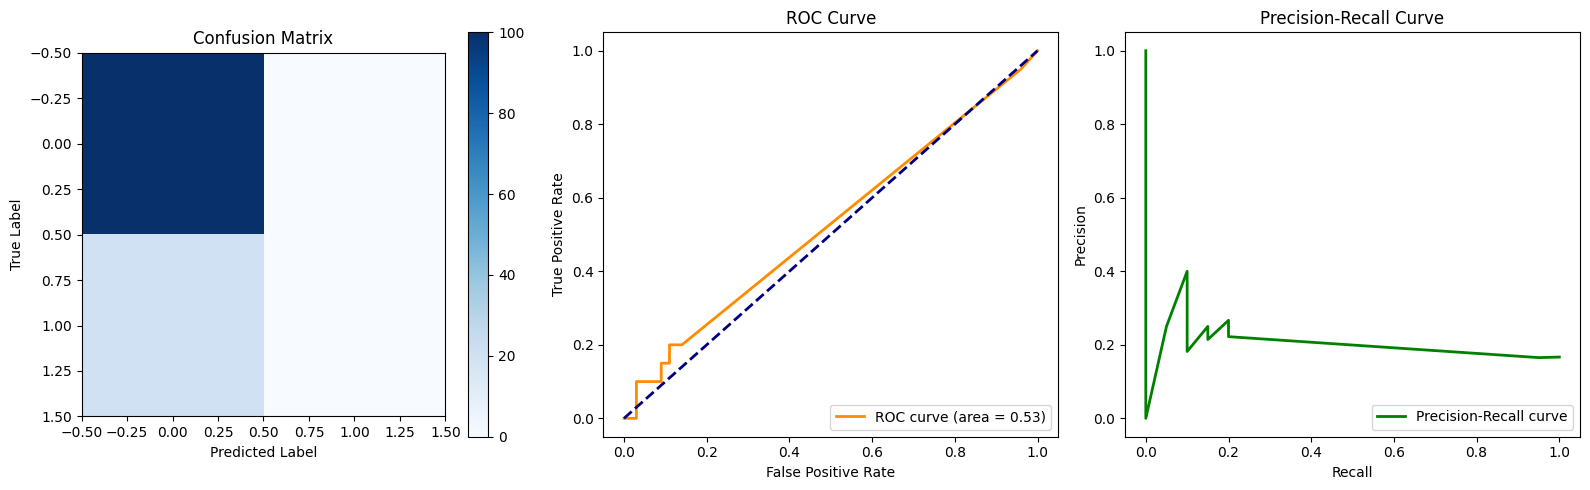

In [31]:
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve, f1_score, accuracy_score
import matplotlib.pyplot as plt
from contextlib import redirect_stdout
import io

# Create a buffer to redirect stdout
stdout_buffer = io.StringIO()

# Redirect stdout to the buffer
with redirect_stdout(stdout_buffer):
    # Make predictions on the test set
    y_pred = (lstm_model.predict(X_test) > 0.5).astype("int32")

    # Confusion Matrix
    conf_matrix = confusion_matrix(y_test, y_pred)

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, lstm_model.predict(X_test))
    roc_auc = auc(fpr, tpr)

    # Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(y_test, lstm_model.predict(X_test))

    # Calculate F1 Score and Accuracy
    f1 = f1_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)

# Plotting
plt.figure(figsize=(16, 5))

# Confusion Matrix
plt.subplot(1, 3, 1)
plt.imshow(conf_matrix, cmap='Blues', interpolation='None')
plt.title('Confusion Matrix')
plt.colorbar()
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# ROC Curve
plt.subplot(1, 3, 2)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")

# Precision-Recall Curve
plt.subplot(1, 3, 3)
plt.plot(recall, precision, color='green', lw=2, label='Precision-Recall curve')
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc="lower right")

# Show metrics
plt.tight_layout()
plt.show()


In [41]:
import nltk

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

def preprocess_file_content(file_path):
    with open(file_path, 'r', encoding='utf-8', errors='ignore') as file:
        content = file.read()

    # Tokenization and removing stop words (adjust as needed)
    tokens = word_tokenize(content)
    tokens = [word.lower() for word in tokens if word.isalpha() and word.lower() not in stopwords.words('english')]

    # Join tokens back into a string
    preprocessed_content = ' '.join(tokens)

    return preprocessed_content


**Test models :**

In [47]:
# Define the plagiarism threshold
plagiarism_threshold = 0.5

# Path to your test file
test_file_path = '/content/test.txt'

# Preprocess the content of the test file
test_file_content = preprocess_file_content(test_file_path)

# Convert the preprocessed content to sequences and pad
test_sequence = tokenizer.texts_to_sequences([test_file_content])
padded_sequence = pad_sequences(test_sequence, maxlen=max_seq_length, padding='post')

# Make predictions with LSTM model
lstm_prediction = lstm_model.predict(padded_sequence)

# Make predictions with CNN model
cnn_prediction = cnn_model.predict(padded_sequence)

# Determine plagiarism status based on the threshold
lstm_result = "Plagiarism" if lstm_prediction > plagiarism_threshold else "Not Plagiarism"
cnn_result = "Plagiarism" if cnn_prediction > plagiarism_threshold else "Not Plagiarism"

# Print the results
print("LSTM Model Prediction:", lstm_result)
print("CNN Model Prediction:", cnn_result)


1/1 [==============================] - 0s 131ms/step
LSTM Model Prediction: Not Plagiarism
CNN Model Prediction: Not Plagiarism
